# Trying to predict the winner of the Eurovision Song Contest based on song characteristics

## Table of content

### Part 1 - Introduction
### Part 2 - Analysis and prediction
- 2.1 - Data exploration
- 2.2 - Random split
- 2.3 - Non-random split

### Part 3 - Conclusion
### Part 4 (appendix) - Data collection and cleaning
- 4.1 -
- 4.2 -
- 4.3 -
- 4.4 -



## Part 1 - Introduction

For the past decade I've casually followed the Eurovision Song Contest (ESC), but this year I was very interested. A good reason to see if I can predict who will be the winner. Of course, this project won't be finished before the final, so it is not *actually* usefull for that. Besides, I want to try something different, which has a higher than zero chance of not working anyway...

The 'standard' way of trying to predict the winner is by analysing historical voting patterns and betting information, as far as I could find. For example, in this 2010 Kaggle competition: https://www.kaggle.com/c/Eurovision2010. And every year there is a lot of discussion about political voting and how much influence that has. 
So I'm going to try something else: 
> is there something about the songs themselves that can help predict the winner?

The way I'll look at this is by taking from Spotify the 'audio features', a set of eleven metrics that describe the song, like 'danceability', 'tempo' and 'acousticness', and some more characteristics like duration. Add to that information on the language of the song and if the performer was also involved in writing the song. And with that information, see if that is enough to predict the winner!

To be honest: I don't think so. A very diverse range of songs has won over the years, and while the song characteristics likely play some part, there are many more influences.

## Part 2 - Analysis and prediction

## # 2.1 - Data exploration

First let's explore the data. I've collected the data by combining data scraped from Wikipedia, data I got with the Spotify API, and data from someone who has done a lot of work tagging each song with additional information, who was nice enough to send me a file. Detailed explanation of how I collected the data is found in part 4.

In [809]:
# importing all the libraries and functions for the analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [810]:
df = pd.read_csv('complete_songs.csv') # complete csv, as made by the steps in part 4
df

,Id,R/O_final,Country,Entry,Artist,Song,Language,Placing,Year,R/O,...,type,analysis_url,duration_ms,time_signature,Title,performer_writer,official_language,performer,year,host
0,17,3.0,United Kingdom,1,Patricia Bredin,All,English,7,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/4Sqs...,162326,0,All,0.0,0.0,Patricia Bredin,1957.0,0.0
1,18,4.0,Italy,2,Nunzio Gallo,Corde della mia chitarra,Italian,6,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/549g...,202600,1,Corde della mia chitarra,0.0,0.0,Nunzio Gallo,1957.0,0.0
2,19,5.0,Austria,1,Bob Martin,"Wohin, kleines Pony?",German,10,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/0mLm...,208641,4,"Wohin, kleines Pony?",0.0,0.0,Bob Martin,1957.0,0.0
3,20,6.0,Netherlands,2,Corry Brokken,Net als toen,Dutch,1,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/7qCu...,203907,4,Net als toen,0.0,0.0,Corry Brokken,1957.0,0.0
4,22,8.0,France,2,Paule Desjardins,La belle amour,French,2,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/1pMD...,188459,4,La belle amour,0.0,0.0,Paule Desjardins,1957.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,1548,9.0,Sweden,59,John Lundvik,Too Late for Love,English,5,2019,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/6Jf8...,178133,4,Too Late For Love,1.0,0.0,John Lundvik,2019.0,0.0
813,1555,15.0,Norway,58,KEiiNO,Spirit in the Sky,English[ac],6,2019,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/7B7O...,185158,4,Spirit In The Sky,1.0,0.0,KEiiNO,2019.0,0.0
814,1561,16.0,United Kingdom,62,Michael Rice,Bigger than Us,English,26,2019,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/1Fzg...,178098,4,Bigger Than Us,0.0,1.0,Michael Rice,2019.0,0.0
815,1592,7.0,Portugal,52,The Black Mamba,Love Is on My Side,English,12,2021,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/4S4R...,175960,4,Love Is On My Side,1.0,0.0,The Black Mamba,2021.0,0.0


To start with, and to check back when I need to select a specific subset of columns, I list the info for all columns. Of the 37 columns, 24 are numerical. But not all of those are relevant, and it turns out that a double column still snuck in: there's 'Year' and 'year'. For a quick overview of potential correlations a heatmap is usefull.

In [811]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 817 non-null    int64  
 1   R/O_final          817 non-null    float64
 2   Country            817 non-null    object 
 3   Entry              817 non-null    int64  
 4   Artist             817 non-null    object 
 5   Song               817 non-null    object 
 6   Language           817 non-null    object 
 7   Placing            817 non-null    int64  
 8   Year               817 non-null    int64  
 9   R/O                817 non-null    float64
 10  Event              817 non-null    object 
 11  name               817 non-null    object 
 12  artists            817 non-null    object 
 13  id                 817 non-null    object 
 14  popularity         817 non-null    int64  
 15  uri                817 non-null    object 
 16  danceability       817 non

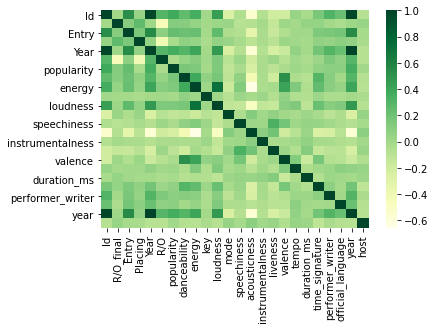

In [812]:
sns.heatmap(df.corr(), cmap='YlGn')
plt.show()

In the heatmap above there are some clear correlations that are irrelevant, like 'year  with 'Id' and the second column 'year'. So I'll select the numerical values that seem relevant in a new dataframe. The values that I've removed are: the second 'year' column, 'entry'(nth participation), 'R/O' (semi-final running order) and 'popularity' (because popularity is more likely to come *after* the contest). In addition, I've made 'Id' the index, since it literally is the identifier for each row. 

In [813]:
df_num_subset = df.iloc[:, [0,1,7,8,16,17,18,19,20,21,22,23,24,25,26,29,30,32,33,36]].copy() #create new dataframe with a subset of columns
df_num_subset.set_index('Id', inplace=True) # set the column 'Id' as index
df_num_subset

,R/O_final,Placing,Year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,performer_writer,official_language,host
Id,,,,,,,,,,,,,,,,,,,
17,3.0,7,1957,0.000,0.139,5,-28.433,1,0.0000,0.9740,0.002670,0.8460,0.000,0.000,162326,0,0.0,0.0,0.0
18,4.0,6,1957,0.364,0.278,7,-9.579,1,0.0354,0.9660,0.000027,0.1080,0.224,95.548,202600,1,0.0,0.0,0.0
19,5.0,10,1957,0.422,0.176,1,-29.190,1,0.1690,0.9770,0.000014,0.3900,0.750,102.560,208641,4,0.0,0.0,0.0
20,6.0,1,1957,0.390,0.193,8,-14.725,1,0.0437,0.7280,0.000000,0.1170,0.504,115.563,203907,4,0.0,0.0,0.0
22,8.0,2,1957,0.242,0.142,10,-18.362,1,0.0433,0.9530,0.000000,0.3470,0.396,68.434,188459,4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,9.0,5,2019,0.401,0.746,0,-4.155,1,0.0734,0.1970,0.000000,0.0657,0.417,104.252,178133,4,1.0,0.0,0.0
1555,15.0,6,2019,0.610,0.754,9,-6.469,0,0.0585,0.1350,0.000000,0.1070,0.357,121.952,185158,4,1.0,0.0,0.0
1561,16.0,26,2019,0.519,0.545,0,-8.124,1,0.0345,0.0146,0.000000,0.0861,0.568,82.025,178098,4,0.0,1.0,0.0


A new heatmap shows that the correlations that are left aren't as strong. There is some correlation between danceability, energy and year, and also between loudness  and energy, and dancebility and valence(if the mood of the song is more happy). None of these are terribly surprising, and the correlations with 'Placing' which is what I want to predict, are weak.

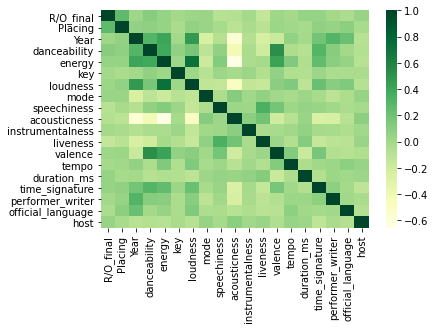

In [814]:
sns.heatmap(df_num_subset.corr(), cmap='YlGn')
plt.show()

However, they are not comletely absent. As you can see in the heatmap, one of the strongest correlations for Placing seems to be the running order. However, there are two reasons why this isn't optimal: 
1. Songs that don't make the final have a running order of 0 and a placing of 0, so that's 10-20 songs each year from 2007 on. That could be enough to create a significant increase in correlation. 
2. Running order of the final is only known days before the final, so even if it has an impact the variable won't be available until just before the final.

So for the first try, I'm going to test the model with and without running order included. Another thing I want to separate is placings in general, and winners. Because a binary classification is less complicated, but also makes the dataset more unbalanced. So I'll make another variable with 1 for winning song and 0 for all others. And then I'll create five subsets:
1. All places with running order
2. All places without running order
3. Winners with running order
4. Winners without running order
5. One with only finalists, and running order included. For this I'll use winners too.

One last thing I want to add is a new column for official language. Because the one I have has 1 if a song is in the official language of the country, but only if the [language rule](https://en.wikipedia.org/wiki/Eurovision_Song_Contest#Song_eligibility_and_languages) was not in place. So I want to separate songs in the official language because it was mandatory from songs in the official language by choice, and non-official language songs.


In [815]:
# set the contitions for official language. There are two periods where the language rule was enforced.
conditions_language = [
    (df_num_subset['official_language'] == 1),
    (df_num_subset['official_language'] == 0) & (df_num_subset['Year'] < 1973),
    (df_num_subset['official_language'] == 0) & (df_num_subset['Year'] > 1976) & (df_num_subset['Year'] < 1999)
    ]
values_language = [1, 2, 2] # set the values for the new column, in order of the conditions
df_num_subset['of_language_rule'] = np.select(conditions_language, values_language) # create a new column based on the conditions and values

# set the conditions for the new 'winner' column
conditions_winner = [
    (df_num_subset['Placing'] == 1),
    (df_num_subset['Placing'] != 1)
    ]
values_winner = [1, 0] # set the values
df_num_subset['winner'] = np.select(conditions_winner, values_winner) # create the column

df_num_subset.head() #check the dataframe with the new columns

,R/O_final,Placing,Year,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,performer_writer,official_language,host,of_language_rule,winner
Id,,,,,,,,,,,,,,,,,,,,,
17,3.0,7,1957,0.000,0.139,5,-28.433,1,0.0000,0.974,...,0.846,0.000,0.000,162326,0,0.0,0.0,0.0,2,0
18,4.0,6,1957,0.364,0.278,7,-9.579,1,0.0354,0.966,...,0.108,0.224,95.548,202600,1,0.0,0.0,0.0,2,0
19,5.0,10,1957,0.422,0.176,1,-29.190,1,0.1690,0.977,...,0.390,0.750,102.560,208641,4,0.0,0.0,0.0,2,0
20,6.0,1,1957,0.390,0.193,8,-14.725,1,0.0437,0.728,...,0.117,0.504,115.563,203907,4,0.0,0.0,0.0,2,1
22,8.0,2,1957,0.242,0.142,10,-18.362,1,0.0433,0.953,...,0.347,0.396,68.434,188459,4,0.0,0.0,0.0,2,0


Next a pairplot to check correlation pair-wise. Binary variables are not really interesting in a pairplot, so I've not included the last 6 variables which are all binary.

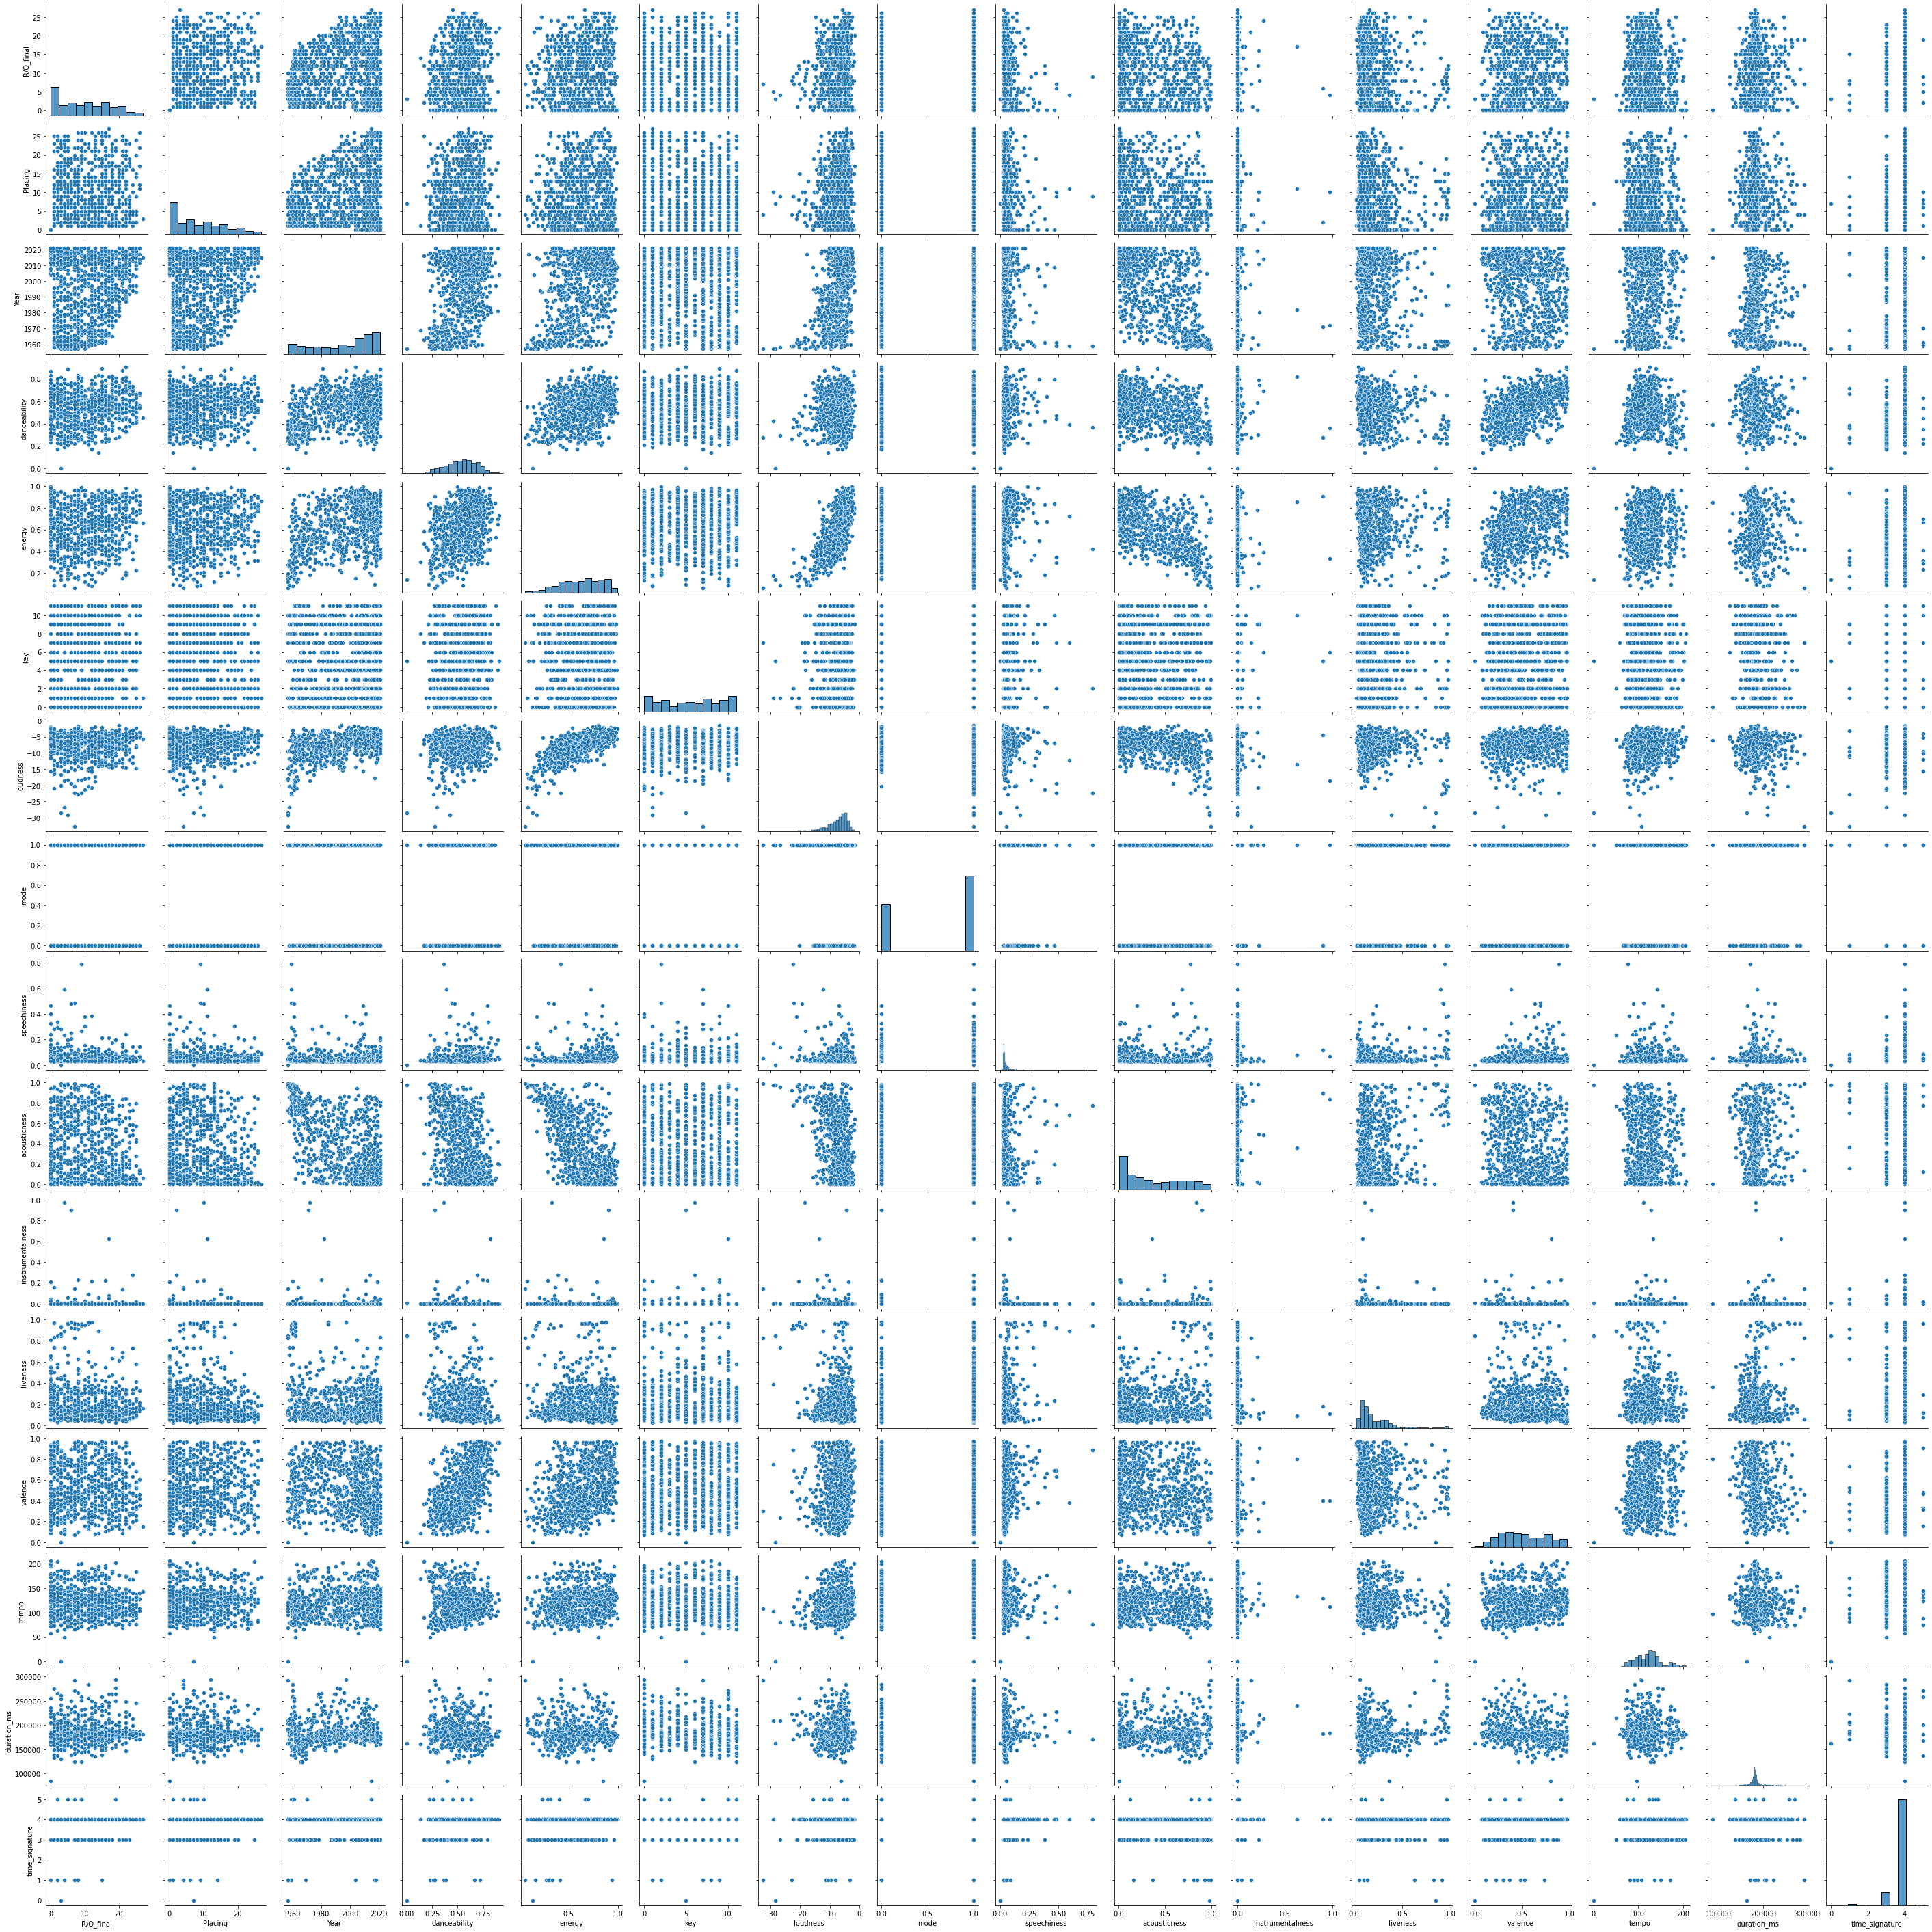

In [8]:
df_num_subset_small = df_num_subset.iloc[:, 0:16].copy() #quite big so takes a while
sns.pairplot(df_num_subset_small)
plt.show()

The plot is too big to see the details, but since most relationships seem to have almost no correlation, I've decided not to split it in multiple plots to see more details.

### 2.2 -  Random split

Now it's time to actually create a model. I've decided to use Random Forest, because from what I've read it seems generally a little more accurate for a bigger variety of datasets. But mostly because I have to start somewhere.

Even though the y variable I want to predict is numerical, it is categorical data. Namely, ordinal data. And for the 'winners' variable that is even clearer, because it's a binary variable: winner, yes or no? So the correct model is the RandomForestClassifier.
I'm trying five different variations of variables, as described above. Split randomly, just to get a first impression. Random state and test size are the same, to make the test and train sets the same for each variation. I figured out the number of estimators with trial and error, the default is 100 but anything higher than 20 doesn't seem to make a difference.

#### First splitting the data into training and test sets

In [819]:
X1 = df_num_subset.iloc[:,[0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]] # All places with running order
y1 = df_num_subset['Placing']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=10)

In [820]:
X2 = df_num_subset.loc[:,'Year':'of_language_rule'] # All places without running order
y2 = df_num_subset['Placing']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=10)

In [821]:
X3 = df_num_subset.iloc[:,[0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]] # Winners with running order
y3 = df_num_subset['winner']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=10)

In [827]:
X4 = df_num_subset.loc[:,'Year':'of_language_rule'] # Winners without running order
y4 = df_num_subset['winner']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=10)

In [828]:
df_ro_yes_finale = df_num_subset[df_num_subset['R/O_final'] != 0] # remove non-finalists
X5 = df_ro_yes_finale.loc[:,'Year':'of_language_rule'] # Winners with running order, only finalists
y5 = df_ro_yes_finale['winner']
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.3, random_state=10)

#### Next creating and fitting the models

In [831]:
rf1 = RandomForestClassifier(random_state=1, n_estimators=5) #RF is a random algorithm, so to get the same results we need to use random_state
rf1 = rf1.fit(X1_train, y1_train)

In [832]:
rf2 = RandomForestClassifier(random_state=1, n_estimators=5) #RF is a random algorithm, so to get the same results we need to use random_state
rf2 = rf2.fit(X2_train, y2_train)

In [833]:
rf3 = RandomForestClassifier(random_state=1, n_estimators=5) #RF is a random algorithm, so to get the same results we need to use random_state
rf3 = rf3.fit(X3_train, y3_train)

In [834]:
rf4 = RandomForestClassifier(random_state=1, n_estimators=5) #RF is a random algorithm, so to get the same results we need to use random_state
rf4 = rf4.fit(X4_train, y4_train)

In [835]:
rf5 = RandomForestClassifier(random_state=1, n_estimators=5) #RF is a random algorithm, so to get the same results we need to use random_state
rf5 = rf5.fit(X5_train, y5_train)

#### And last calculating the accuracy score

In [836]:
rf1.score(X1_test,y1_test)

0.22357723577235772

In [837]:
rf2.score(X2_test,y2_test)

0.13821138211382114

In [838]:
rf3.score(X3_test,y3_test)

0.943089430894309

In [839]:
rf4.score(X4_test,y4_test)

0.9390243902439024

In [840]:
rf5.score(X5_test,y5_test)

0.8985507246376812

It is clear from the accuracy scores that none of these models perform very well. At first glance the last three seem a lot better, but that is deceptive: 50 out of 817 songs are winners, so 96% percent of songs are not winners. By just saying all songs are not winners, the result would be better than the best of these (variation 3 with 94% accuracy).
But let's look at the precision and recall for the last three.

In [844]:
y3_pred = rf3.predict(X3_test) #the predicted values
cm3 = confusion_matrix(y3_test, y3_pred) #creates a "confusion matrix"
cm3 = pd.DataFrame(cm3, index=['no winner (actual)', 'winner (actual)'], columns = ['no winner (pred)', 'winner (pred)']) #label and make df

y4_pred = rf4.predict(X4_test) #the predicted values
cm4 = confusion_matrix(y4_test, y4_pred) #creates a "confusion matrix"
cm4 = pd.DataFrame(cm4, index=['no winner (actual)', 'winner (actual)'], columns = ['no winner (pred)', 'winner (pred)']) #label and make df

y5_pred = rf5.predict(X5_test) #the predicted values
cm5 = confusion_matrix(y5_test, y5_pred) #creates a "confusion matrix"
cm5 = pd.DataFrame(cm5, index=['no winner (actual)', 'winner (actual)'], columns = ['no winner (pred)', 'winner (pred)']) #label and make df
print('Confusion matrix variation 3')
print(cm3)
print()
print('Confusion matrix variation 4')
print(cm4)
print()
print('Confusion matrix variation 5')
print(cm5)

Confusion matrix variation 3
                    no winner (pred)  winner (pred)
no winner (actual)               232              1
winner (actual)                   13              0

Confusion matrix variation 4
                    no winner (pred)  winner (pred)
no winner (actual)               230              3
winner (actual)                   12              1

Confusion matrix variation 5
                    no winner (pred)  winner (pred)
no winner (actual)               186              4
winner (actual)                   17              0


As I already expected, the prediction is fairly useless. variation 4 is the only one where there is a correctly predicted winner, though a few false positives might be alright. I'll come back to that later.

The final test I want to do is split the data in a non-random way. I'm only going to try the 4th variation, which is 'winners without running order'. If this is truly the best option is hard to determine, because all options are garbage... 

I'm making three groups: training, testing and applying (for trying to get a prediction). I'll split by year, with 2021 as the final set and the rest split approximately 70/30. For 63 contests (64 minus 2021), 45 is close to 70%. However the dataset does not include the same amount of songs for each year, to mitigate this I shuffle the dataset first. The result is not an exact 70/30 split, but comes fairly close.

### 2.3 - Not-random split

In [845]:
apply_df = df_num_subset[df_num_subset['Year'] == 2021].copy() # A dataframe with only 2021
train_test_set = df_num_subset[df_num_subset['Year'] != 2021].copy() # A dataframe without 2021

In [893]:
# from https://stackoverflow.com/questions/61529720/how-to-shuffle-a-pandas-groupby-object
years = train_test_set['Year'].unique() #Get a list of all years
np.random.seed(10) # set seed (same as random_state in train_test_split) for reproducibility
train_years = np.random.choice(years, size=45, replace=False) #select 45 years from the list pseudo-randomly

train_idxs = train_test_set["Year"].isin(train_years) # create boolean that checks wether a song's year is included in train_years
train_df = train_test_set[train_idxs] # create dataframe from only the selected years
test_df = train_test_set[~train_idxs] # create a dataframe with only the not selected years

In [894]:
# Split the three df in X and y
X_train = train_df.loc[:,'Year':'of_language_rule'] # Training X and y
y_train = train_df['winner']
X_test = test_df.loc[:,'Year':'of_language_rule'] # Testing X and y
y_test = test_df['winner']
X_apply = apply_df.loc[:,'Year':'of_language_rule'] # Apply X and y
y_apply = apply_df['winner']

In [895]:
rf = RandomForestClassifier(random_state=1, n_estimators=5) #create the model
rf = rf.fit(X_train, y_train) # fit the model

In [896]:
rf.score(X_test,y_test) #test the accuracy

0.9333333333333333

Unfortunately, the way the data is pslit doesn't seem to make a noticable difference. The accuracy score is still below the 'nobody wins' 96% threshold, and is very similar to the model trained on a ranomly split dataset. However, for trying to predict a certain year it is still usefull to have at least the 'apply' set selected non randomly. But first let's look at the precision and recall.

In [897]:
y_pred = rf.predict(X_test) #the predicted values
cm = confusion_matrix(y_test, y_pred) #creates a "confusion matrix"
cm = pd.DataFrame(cm, index=['no winner (actual)', 'winner (actual)'], columns = ['no winner (pred)', 'winner (pred)']) 
cm

,no winner (pred),winner (pred)
no winner (actual),252,2
winner (actual),16,0


In [898]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       254
           1       0.00      0.00      0.00        16

    accuracy                           0.93       270
   macro avg       0.47      0.50      0.48       270
weighted avg       0.88      0.93      0.91       270



As you can see, the recall is very good for predicting the non-winners, and the precision is almost as good, most non-winners are correctly classified as such. For precitiong the winners however, both are no good at all with a precentage of <0.5%.

The last thing to do is apply the model to the data of a single year and see how that goes.

In [899]:
yA_pred = rf.predict(X_apply) #the predicted values
cmA = confusion_matrix(y_apply, yA_pred) #creates a "confusion matrix"
cmA = pd.DataFrame(cmA, index=['no winner (actual)', 'winner (actual)'], columns = ['no winner (pred)', 'winner (pred)']) 
cmA

,no winner (pred),winner (pred)
no winner (actual),27,1
winner (actual),1,0


At least a winner is predicted, even if it is not the right one. If this 'predicted winner' is not the actual winner, but still in the top 10, it won't be a total failure. Let's add a column with predictions to the dataframe, and also one with the probability to know is which songs are *more likely* to do well. 

In [900]:
apply_df['prediction'] = yA_pred # add column with prediction
prob = rf.predict_proba(X_apply) # calculate probability
apply_df['probability'] = prob[:,1] # add column with probability
apply_df.sort_values(by='probability',ascending=False, inplace=True) # sort by highest probability
apply_df # show data frame

,R/O_final,Placing,Year,danceability,energy,key,loudness,mode,speechiness,acousticness,...,tempo,duration_ms,time_signature,performer_writer,official_language,host,of_language_rule,winner,probability,prediction
Id,,,,,,,,,,,,,,,,,,,,,
1586,0.0,0,2021,0.690,0.771,11,-7.064,0,0.0262,0.40300,...,131.946,180813,4,0.0,0.0,0.0,0,0,0.6,1
1577,0.0,0,2021,0.582,0.693,10,-5.522,0,0.1350,0.12500,...,119.626,174125,4,0.0,0.0,0.0,0,0,0.2,0
1584,10.0,10,2021,0.533,0.910,2,-4.526,0,0.0435,0.02130,...,146.869,180000,4,0.0,0.0,0.0,0,0,0.2,0
1572,1.0,16,2021,0.660,0.664,9,-7.780,0,0.1340,0.00395,...,113.994,181547,4,0.0,0.0,0.0,0,0,0.2,0
1600,15.0,25,2021,0.827,0.837,5,-5.322,0,0.2140,0.19000,...,113.889,176997,4,1.0,0.0,0.0,0,0,0.2,0
1598,9.0,26,2021,0.678,0.819,6,-4.646,1,0.0577,0.00283,...,125.968,175914,4,1.0,1.0,0.0,1,0,0.2,0
1578,21.0,20,2021,0.706,0.675,4,-5.756,0,0.0386,0.01280,...,99.942,160981,4,0.0,0.0,0.0,0,0,0.2,0
1575,4.0,19,2021,0.491,0.728,5,-4.482,1,0.0428,0.04790,...,80.239,176507,4,1.0,0.0,0.0,0,0,0.0,0
1595,0.0,0,2021,0.656,0.628,10,-7.617,0,0.1440,0.03870,...,150.060,180000,4,1.0,0.0,0.0,0,0,0.0,0


Unfortunately,  the predicted winner is not in the top 10. Even worse, it wasn't even in the final! By changing the seed value when selecting the training set it is possible to occasionally get a more likely winner, but this is just coincidence.
To see which song is the predicted winner I've selected it below from the original dataframe:
> Artist: Rafał - Song: The Ride (Poland)

He scored 14th out of 17 in the second semi-final, so not particularly a winner...

In [902]:
df[df['Id'] == 1586]

,Id,R/O_final,Country,Entry,Artist,Song,Language,Placing,Year,R/O,...,type,analysis_url,duration_ms,time_signature,Title,performer_writer,official_language,performer,year,host
478,1586,0.0,Poland,23,Rafał,The Ride,English,0,2021,6.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/3vTq...,180813,4,The Ride,0.0,0.0,RAFAŁ,2021.0,0.0


## Part 3 - Conclusion

The conclusion of this project is clear: with these variables it is impossible to predict the winner. Even though I expected it, I had still hoped for a little bit more, but I think it definitely shows how complicated this is.

One thing I haven't touched on at all that would be interesting for a follow-up project is the way the songs influence each other, both within a single contest and over the years. 
For example, the winner of 2011 (Ell & Nikki - Running scared) is regarded as very weak winner by a lot of fans, and unlikely to have won in the years before or after. And this year (2021), there were several 'strong female bops' (not my words), and some fans think that these might have 'cancelled' each other, by spreading votes between them that otherwise would have gone to one song. Also, did Måneskin win partly because their song was very different from Duncan Laurence's 'Arcade'?

These are all questions that could be explored further in another project.

## 4 - Collection and cleaning the data

### 4.1 - Wikipedia

Tutorial:

I started out with this tutorial, but it was quite complicated. Then it turned out that at the end another method is mentioned, which only uses pandas and needs literally 2 lines of code...

https://alanhylands.com/how-to-web-scrape-wikipedia-python-urllib-beautiful-soup-pandas/

In [1]:
import pandas as pd

The information on the songs is split over two pages on Wikipedia, one with all contests from 1956 to 2003, and one with all contests from 2004 onward. In 2004 was the first time that a semi-final was held, all the years after that there has been either one or two semi-finals. Because the unit of observation is a song, the data from the semi-finals needs to be combined with the finals so that there is only one entry for each song. Each song has a unique ID, so by separating the semi-finals and finals while scraping I can merge those two datasets later.

For the first edition in 1956 only the winner is known, so I have decided not to include that one.

Note: In this part I have created a lot of csv's inbetween, as backup and to be able to continue later from csv instead of running everything again.

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_Eurovision_Song_Contest_entries"

s_tables = pd.read_html(url, match='Semi-final') 
semis = pd.concat(s_tables)

f_tables = pd.read_html(url, match='Final') 
finals = pd.concat(f_tables[:16])

url2 = 'https://en.wikipedia.org/wiki/List_of_Eurovision_Song_Contest_entries_(1956%E2%80%932003)'
tables = pd.read_html(url2, match='Placing')
finals2 = pd.concat(tables[1:])

# semis.to_csv('semis_2004-2021.csv', index=False)
# finals.to_csv('finals_2004-2021.csv', index=False)
# finals2.to_csv('finals_1957-2003.csv', index=False)

In [3]:
semis.head() 

,#,R/O,Country,#.1,Artist,Song,Language,Placing
0,918,1,Finland,38,Jari Sillanpää,"""Takes 2 to Tango""",English,14
1,919,2,Belarus,1,Aleksandra and Konstantin,"""My Galileo""",English,19
2,920,3,Switzerland,45,Piero Esteriore & The MusicStars,"""Celebrate!""",English,22 ◁
3,921,4,Latvia,5,Fomins and Kleins,"""Dziesma par laimi""",Latvian,17
4,922,5,Israel,27,David D'Or,"""Leha'amin"" (להאמין)","Hebrew, English",11


In [4]:
finals.head()

,#,R/O,Country,#.1,Artist,Song,Language,Placing
0,940,1,Spain,44,Ramón,"""Para llenarme de ti""",Spanish,10
1,941,2,Austria,41,Tie Break,"""Du bist""",German,21
2,942,3,Norway,43,Knut Anders Sørum,"""High""",English,24 ◁
3,943,4,France,47,Jonatan Cerrada,"""À chaque pas""","French, Spanish",15
4,937,5,Serbia and Montenegro,1,Željko Joksimović & Ad-Hoc Orchestra,"""Lane moje"" (Лане моје)",Serbian,2


In [5]:
finals2.head()

,#,R/O,Country,#.1,Artist,Song,Language,Placing
0,15,1,Belgium,2,Bobbejaan Schoepen,"""Straatdeuntje""",Dutch,8
1,16,2,Luxembourg,2,Danièle Dupré,"""Amours mortes (tant de peine)""",French,4
2,17,3,United Kingdom,1,Patricia Bredin,"""All""",English,7
3,18,4,Italy,2,Nunzio Gallo,"""Corde della mia chitarra""",Italian,6
4,19,5,Austria,1,Bob Martin,"""Wohin, kleines Pony?""",German,10 ◁


One thing that is not included in the tables is the year of each contest, because this was instead mentioned in the caption outside each table. In the end I decided to just add the years myself in Excel, because that would be less complicated. I added a column 'Year', and a column 'Event' for the semifinals, to indicate semi-final 1 or 2 or only a single semi-final.

In [6]:
semis_year = pd.read_csv('semis.csv', sep=';')
finals_old = pd.read_csv('finals_1957-2003_with_year.csv', sep=';')
finals_new = pd.read_csv('finals_2004-2021_with_year.csv', sep=';')

In [7]:
semis_year #example of the new dataframe with info added in Excel

,Id,R/O,Country,Entry,Artist,Song,Language,Placing,Year,Event
0,918,1,Finland,38,Jari Sillanpää,"""Takes 2 to Tango""",English,14,2004,SF
1,919,2,Belarus,1,Aleksandra and Konstantin,"""My Galileo""",English,19,2004,SF
2,920,3,Switzerland,45,Piero Esteriore & The MusicStars,"""Celebrate!""",English,22 ◁,2004,SF
3,921,4,Latvia,5,Fomins and Kleins,"""Dziesma par laimi""",Latvian,17,2004,SF
4,922,5,Israel,27,David D'Or,"""Leha'amin"" (להאמין)","Hebrew, English",11,2004,SF
...,...,...,...,...,...,...,...,...,...,...
550,1593,13,Bulgaria,13,Victoria,"""Growing Up Is Getting Old""",English,3 †,2021,SF2
551,1594,14,Finland,54,Blind Channel,"""Dark Side""",English,5 †,2021,SF2
552,1595,15,Latvia,21,Samanta Tīna,"""The Moon is Rising""",English,17 ◁,2021,SF2
553,1596,16,Switzerland,61,Gjon's Tears,"""Tout l'Univers""",French,1 †,2021,SF2


Some more cleanup is needed, in the placing column there are several symbols used to identify qualifiers (in semis) and last place. These need to go and the values are converted to integers.

In [10]:
semis_year['Placing'] = semis_year['Placing'].str.extract('(\d+)', expand=False).astype(int)

In [11]:
semis_year.info() #check if 'Placing' is an integer now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        555 non-null    int64 
 1   R/O       555 non-null    int64 
 2   Country   555 non-null    object
 3   Entry     555 non-null    int64 
 4   Artist    555 non-null    object
 5   Song      555 non-null    object
 6   Language  555 non-null    object
 7   Placing   555 non-null    int32 
 8   Year      555 non-null    int64 
 9   Event     555 non-null    object
dtypes: int32(1), int64(4), object(5)
memory usage: 41.3+ KB


In [12]:
finals_old['Placing_final'] = finals_old['Placing_final'].str.extract('(\d+)', expand=False).astype(int)

In [13]:
finals_new['Placing_final'] = finals_new['Placing_final'].str.extract('(\d+)', expand=False).astype(int)

Next I select only the non qualifying entries from the semi-finals. In most semi-finals, the top 10 entries go to the final, but in 2008 and 2009 the top 9 + a jury wildcard qualified, which makes this more complicated...
By looking it up on Wikipedia I could select the correct rows step by step

In [14]:
semis_nq = semis_year[((semis_year['Year'] != (2008)) & (semis_year['Year'] != (2009)) ) & (semis_year['Placing'] > 10)] #select non-qualifying songs for each year except 2008 & 2009
semis_nq_2008 = semis_year[(semis_year['Year'] == 2008) & (semis_year['Placing'] > 9)] # select non-qualifying songs, but with the wildcard still included for 2008
semis_nq_2009 = semis_year[(semis_year['Year'] == 2009) & (semis_year['Placing'] > 9)] # same in 2009
semis_nq_2008 = semis_nq_2008[((semis_nq_2008['Event'] == 'SF1') & (semis_nq_2008['Placing'] != 10)) | ((semis_nq_2008['Event'] == 'SF2') & (semis_nq_2008['Placing'] != 12))] #remove wildcards
semis_nq_2009 = semis_nq_2009[((semis_nq_2009['Event'] == 'SF1') & (semis_nq_2009['Placing'] != 12)) | ((semis_nq_2009['Event'] == 'SF2') & (semis_nq_2009['Placing'] != 13))]
semis_nq = pd.concat([semis_nq, semis_nq_2008, semis_nq_2009], ignore_index=True) # add dataframes together again
semis_nq #show non-qualifyers dataframe

,Id,R/O,Country,Entry,Artist,Song,Language,Placing,Year,Event
0,918,1,Finland,38,Jari Sillanpää,"""Takes 2 to Tango""",English,14,2004,SF
1,919,2,Belarus,1,Aleksandra and Konstantin,"""My Galileo""",English,19,2004,SF
2,920,3,Switzerland,45,Piero Esteriore & The MusicStars,"""Celebrate!""",English,22,2004,SF
3,921,4,Latvia,5,Fomins and Kleins,"""Dziesma par laimi""",Latvian,17,2004,SF
4,922,5,Israel,27,David D'Or,"""Leha'amin"" (להאמין)","Hebrew, English",11,2004,SF
...,...,...,...,...,...,...,...,...,...,...
250,1139,7,Cyprus,27,Christina Metaxa,"""Firefly""",English,14,2009,SF2
251,1140,8,Slovakia,4,Kamil Mikulčík & Nela Pocisková,"""Leť tmou""",Slovak,18,2009,SF2
252,1142,10,Slovenia,15,Quartissimo feat. Martina,"""Love Symphony""","English, Slovene",16,2009,SF2
253,1143,11,Hungary,8,Zoli Ádok,"""Dance with Me""",English,15,2009,SF2


In [15]:
semis_nq['Placing'] = '0'
semis_nq['Placing'].astype(int)

0      0
1      0
2      0
3      0
4      0
      ..
250    0
251    0
252    0
253    0
254    0
Name: Placing, Length: 255, dtype: int32

I thought there where rankings with all the songs ordered, including the non-qualifyers, but it turned out those were fan-made and not official. So I decided to give them all the placing value 0, instead of trying to create my own ultimate ranking.

At first I had another plan for combining the data from semi-final and final, so I had changed some column headers, but with the way I combine it now I have all the non-qualifiers just with '0' as place, so it makes more sense to just put it all together in one column.

In [16]:
finals_new = finals_new.rename(columns={'Placing_final': 'Placing'})
finals_old = finals_old.rename(columns={'Placing_final': 'Placing'})

In [17]:
e2004_2021 = pd.concat([semis_nq, finals_new], ignore_index=True) #add all songs from 2004-2021 together

In [18]:
e2004_2021.sort_values('Id')

,Id,R/O,Country,Entry,Artist,Song,Language,Placing,Year,Event,R/O_final
0,918,1.0,Finland,38,Jari Sillanpää,"""Takes 2 to Tango""",English,0,2004,SF,NaN
1,919,2.0,Belarus,1,Aleksandra and Konstantin,"""My Galileo""",English,0,2004,SF,NaN
2,920,3.0,Switzerland,45,Piero Esteriore & The MusicStars,"""Celebrate!""",English,0,2004,SF,NaN
3,921,4.0,Latvia,5,Fomins and Kleins,"""Dziesma par laimi""",Latvian,0,2004,SF,NaN
4,922,5.0,Israel,27,David D'Or,"""Leha'amin"" (להאמין)","Hebrew, English",0,2004,SF,NaN
...,...,...,...,...,...,...,...,...,...,...,...
672,1599,NaN,Spain,60,Blas Cantó,"""Voy a quedarme""",Spanish,24,2021,NaN,13.0
674,1600,NaN,Germany,64,Jendrik,"""I Don't Feel Hate""",English[c],25,2021,NaN,15.0
679,1601,NaN,France,63,Barbara Pravi,"""Voilà""",French,2,2021,NaN,20.0
682,1602,NaN,Netherlands,61,Jeangu Macrooy,"""Birth of a New Age""","English, Sranan Tongo",23,2021,NaN,23.0


In [19]:
all_songs = pd.concat([finals_old, e2004_2021], ignore_index=True) # add all songs together

In [21]:
all_songs.sort_values('Id') #all songs sorted by Id, so in the original order

,Id,R/O_final,Country,Entry,Artist,Song,Language,Placing,Year,R/O,Event
0,15,1.0,Belgium,2,Bobbejaan Schoepen,"""Straatdeuntje""",Dutch,8,1957,NaN,NaN
1,16,2.0,Luxembourg,2,Danièle Dupré,"""Amours mortes (tant de peine)""",French,4,1957,NaN,NaN
2,17,3.0,United Kingdom,1,Patricia Bredin,"""All""",English,7,1957,NaN,NaN
3,18,4.0,Italy,2,Nunzio Gallo,"""Corde della mia chitarra""",Italian,6,1957,NaN,NaN
4,19,5.0,Austria,1,Bob Martin,"""Wohin, kleines Pony?""",German,10,1957,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1575,1599,13.0,Spain,60,Blas Cantó,"""Voy a quedarme""",Spanish,24,2021,NaN,NaN
1577,1600,15.0,Germany,64,Jendrik,"""I Don't Feel Hate""",English[c],25,2021,NaN,NaN
1582,1601,20.0,France,63,Barbara Pravi,"""Voilà""",French,2,2021,NaN,NaN
1585,1602,23.0,Netherlands,61,Jeangu Macrooy,"""Birth of a New Age""","English, Sranan Tongo",23,2021,NaN,NaN


In [22]:
all_songs['Song'] = all_songs['Song'].str.replace('"', '' ) #remove the unnecesary quotes on the song titles

In [23]:
all_songs['Id'].value_counts()

16      1
563     1
559     1
557     1
555     1
       ..
1070    1
1068    1
1066    1
1064    1
1603    1
Name: Id, Length: 1589, dtype: int64

No double Id's, and a total of 1603-14=1589 songs, means that I have every song since 1957 once in the dataframe. (The first year 1956 only 7 countries participated, but each with two songs. Unfortunately only the winner is known, so I haven't included it.)

In [24]:
all_songs.to_csv('all_songs.csv', index=False) # for backup

### 4.2 - Spotify

How I got the data from Spotify

In [25]:
import spotipy
import json
import time

from spotipy.oauth2 import SpotifyClientCredentials

In [26]:
client_credentials_manager = SpotifyClientCredentials(client_id = '3ca7c518b5714571a65af51a43c2230b',
                                                      client_secret = '440fc8b232e746f0a3c87f05864fa099')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

I used the playlist [Ultimate Eurovision Song Contest 1956-2021](https://open.spotify.com/playlist/4L8d8g6SXH9eEON63qEUWH?si=52ed0aa2d95a4395) by Daniel Tew, which includes 1289 songs.

In [27]:
playlist_id = 'spotify:playlist:4L8d8g6SXH9eEON63qEUWH'
username = 'spotify:user:1125043597'

In [28]:
# function to get all the tracks from the playlist
def get_playlist_tracks(username,playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [29]:
df_track = get_playlist_tracks(username, playlist_id) #run function
df_track = pd.DataFrame(df_track) #create dataframe, which includes lists nd dictionaries
df_track = list(df_track['track']) # extract deeper layer from the dataframe
df_track = pd.DataFrame(df_track) # create dataframe from deeper layer
df_track

,album,artists,available_markets,disc_number,duration_ms,episode,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track,track_number,type,uri
0,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,179200,False,False,{'isrc': 'AT2DY2100003'},{'spotify': 'https://open.spotify.com/track/7C...,https://api.spotify.com/v1/tracks/7Ca1YA47yXQB...,7Ca1YA47yXQByUTX2jHMlN,False,Karma,65,None,True,1,track,spotify:track:7Ca1YA47yXQByUTX2jHMlN
1,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,188889,False,False,{'isrc': 'ATR981206752'},{'spotify': 'https://open.spotify.com/track/0Y...,https://api.spotify.com/v1/tracks/0Y6JVcxzdXaN...,0Y6JVcxzdXaNwHROjoyuww,False,Fall from the Sky,39,https://p.scdn.co/mp3-preview/c57957eb2c6434df...,True,1,track,spotify:track:0Y6JVcxzdXaNwHROjoyuww
2,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,194451,False,False,{'isrc': 'AT2DY1900002'},{'spotify': 'https://open.spotify.com/track/7p...,https://api.spotify.com/v1/tracks/7p83db7oriaC...,7p83db7oriaCul8WzoLr6f,False,Ktheju Tokës,32,None,True,1,track,spotify:track:7p83db7oriaCul8WzoLr6f
3,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,190491,False,False,{'isrc': 'DKUM71800092'},{'spotify': 'https://open.spotify.com/track/6v...,https://api.spotify.com/v1/tracks/6vGLWavGUuAs...,6vGLWavGUuAs9vpZyprUl0,False,Mall,36,None,True,1,track,spotify:track:6vGLWavGUuAs9vpZyprUl0
4,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,[],1,176222,False,False,{'isrc': 'DKUM71700124'},{'spotify': 'https://open.spotify.com/track/4c...,https://api.spotify.com/v1/tracks/4cxdvy2QfC7Y...,4cxdvy2QfC7Yzh5m8zwX3i,False,World,0,None,True,1,track,spotify:track:4cxdvy2QfC7Yzh5m8zwX3i
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,178760,False,False,{'isrc': 'HRA040754317'},{'spotify': 'https://open.spotify.com/track/0D...,https://api.spotify.com/v1/tracks/0DwGK5kdjM0A...,0DwGK5kdjM0AuqnNoUeYXT,False,Čežnja,5,https://p.scdn.co/mp3-preview/73ebff8d8bb244df...,True,10,track,spotify:track:0DwGK5kdjM0AuqnNoUeYXT
1285,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,201360,False,False,{'isrc': 'HRA046330151'},{'spotify': 'https://open.spotify.com/track/4m...,https://api.spotify.com/v1/tracks/4mQlXKhbczdB...,4mQlXKhbczdBxf9c1cMW3J,False,Brodovi,5,https://p.scdn.co/mp3-preview/686a7cd004310ce3...,True,7,track,spotify:track:4mQlXKhbczdBxf9c1cMW3J
1286,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,185613,False,False,{'isrc': 'HRA046258487'},{'spotify': 'https://open.spotify.com/track/09...,https://api.spotify.com/v1/tracks/094TgzS2AoVx...,094TgzS2AoVxoju4spibLz,False,Ne Pali Svetla U Sumrak,6,https://p.scdn.co/mp3-preview/f07740a3a33d402b...,True,22,track,spotify:track:094TgzS2AoVxoju4spibLz
1287,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,197320,False,False,{'isrc': 'HRA046168368'},{'spotify': 'https://open.spotify.com/track/5i...,https://api.spotify.com/v1/tracks/5iifgVNCvItr...,5iifgVNCvItrSpFNxKjAgG,False,Neke Davne Zvezde,4,https://p.scdn.co/mp3-preview/f55e6c10adc79ef1...,True,

Local tracks were a problem in my test playlist, so to be sure I removed them (if there are any). And a whole bunch of column are unnecessary, so I removed those as well.

In [30]:
df_track = df_track[df_track['is_local'] == False]

In [31]:
df_track.drop(inplace=True, columns=['type', 'track_number', 'track', 'preview_url', 'is_local', 'href', 'external_urls',
                                    'external_ids', 'explicit', 'episode', 'disc_number', 'available_markets', 'album', 'duration_ms'])

I still need to get the artists out of their dictionary column, so that's the next bit

In [32]:
df_artist = list(df_track['artists']) # create list of dictionaries from the dataframe column
artists = [] # empty list to put artist names
i=0 # start of loop
for i in range(len(df_artist)): # loop through list and extract artist name(s) from dictionary
    artist = df_artist[i][0]['name']
    artists.append(artist) # add to list
df_track['artists'] = artists # add to dataframe
df_track

,artists,id,name,popularity,uri
0,Anxhela Peristeri,7Ca1YA47yXQByUTX2jHMlN,Karma,65,spotify:track:7Ca1YA47yXQByUTX2jHMlN
1,Arilena Ara,0Y6JVcxzdXaNwHROjoyuww,Fall from the Sky,39,spotify:track:0Y6JVcxzdXaNwHROjoyuww
2,Jonida Maliqi,7p83db7oriaCul8WzoLr6f,Ktheju Tokës,32,spotify:track:7p83db7oriaCul8WzoLr6f
3,Eugent Bushpepa,6vGLWavGUuAs9vpZyprUl0,Mall,36,spotify:track:6vGLWavGUuAs9vpZyprUl0
4,Lindita,4cxdvy2QfC7Yzh5m8zwX3i,World,0,spotify:track:4cxdvy2QfC7Yzh5m8zwX3i
...,...,...,...,...,...
1284,Vice Vukov,0DwGK5kdjM0AuqnNoUeYXT,Čežnja,5,spotify:track:0DwGK5kdjM0AuqnNoUeYXT
1285,Vice Vukov,4mQlXKhbczdBxf9c1cMW3J,Brodovi,5,spotify:track:4mQlXKhbczdBxf9c1cMW3J
1286,Lola Novakovic,094TgzS2AoVxoju4spibLz,Ne Pali Svetla U Sumrak,6,spotify:track:094TgzS2AoVxoju4spibLz
1287,Ljiljana Petrovic,5iifgVNCvItrSpFNxKjAgG,Neke Davne Zvezde,4,spotify:track:5iifgVNCvItrSpFNxKjAgG


In [34]:
uris = list(df_track['uri']) # get uri's from dataframe, these are neccesary to get the audio features
all_features = []

In [38]:
# Code from https://github.com/plamere/spotipy/blob/master/examples/audio_features.py
start = time.time()
for uri in uris:
    features = sp.audio_features(uri)
    delta = time.time() - start
    for feature in features:
        time.sleep(0.4)
        analysis = sp._get(feature['analysis_url'])
        all_features.extend(features)
        
print("features retrieved in %.2f seconds" % (delta,))

features retrieved in 869.12 seconds


In [39]:
df_feat = pd.DataFrame(all_features)  # create dataframe with features   
df_feat

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.515,0.627,7,-10.083,0,0.0448,0.00371,0.000000,0.1270,0.192,149.987,audio_features,7Ca1YA47yXQByUTX2jHMlN,spotify:track:7Ca1YA47yXQByUTX2jHMlN,https://api.spotify.com/v1/tracks/7Ca1YA47yXQB...,https://api.spotify.com/v1/audio-analysis/7Ca1...,179200,4
1,0.369,0.677,7,-3.382,0,0.0365,0.01870,0.000000,0.3120,0.243,144.755,audio_features,0Y6JVcxzdXaNwHROjoyuww,spotify:track:0Y6JVcxzdXaNwHROjoyuww,https://api.spotify.com/v1/tracks/0Y6JVcxzdXaN...,https://api.spotify.com/v1/audio-analysis/0Y6J...,188890,4
2,0.531,0.611,1,-5.119,1,0.0387,0.01620,0.000000,0.1100,0.597,115.058,audio_features,7p83db7oriaCul8WzoLr6f,spotify:track:7p83db7oriaCul8WzoLr6f,https://api.spotify.com/v1/tracks/7p83db7oriaC...,https://api.spotify.com/v1/audio-analysis/7p83...,194452,4
3,0.322,0.807,4,-4.468,1,0.0368,0.01060,0.000000,0.1680,0.493,189.743,audio_features,6vGLWavGUuAs9vpZyprUl0,spotify:track:6vGLWavGUuAs9vpZyprUl0,https://api.spotify.com/v1/tracks/6vGLWavGUuAs...,https://api.spotify.com/v1/audio-analysis/6vGL...,190491,3
4,0.426,0.788,0,-4.566,1,0.0404,0.11000,0.000000,0.2890,0.294,84.965,audio_features,4cxdvy2QfC7Yzh5m8zwX3i,spotify:track:4cxdvy2QfC7Yzh5m8zwX3i,https://api.spotify.com/v1/tracks/4cxdvy2QfC7Y...,https://api.spotify.com/v1/audio-analysis/4cxd...,176223,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,0.245,0.365,0,-7.115,0,0.0316,0.89000,0.000001,0.0942,0.134,134.910,audio_features,0DwGK5kdjM0AuqnNoUeYXT,spotify:track:0DwGK5kdjM0AuqnNoUeYXT,https://api.spotify.com/v1/tracks/0DwGK5kdjM0A...,https://api.spotify.com/v1/audio-analysis/0DwG...,178760,5
1285,0.172,0.449,0,-7.402,1,0.0323,0.84200,0.001260,0.1360,0.238,78.569,audio_features,4mQlXKhbczdBxf9c1cMW3J,spotify:track:4mQlXKhbczdBxf9c1cMW3J,https://api.spotify.com/v1/tracks/4mQlXKhbczdB...,https://api.spotify.com/v1/audio-analysis/4mQl...,201360,4
1286,0.440,0.472,3,-5.283,1,0.0324,0.87800,0.000000,0.3000,0.316,104.176,audio_features,094TgzS2AoVxoju4spibLz,spotify:track:094TgzS2AoVxoju4spibLz,https://api.spotify.com/v1/tracks/094TgzS2AoVx...,https://api.spotify.com/v1/audio-analysis/094T...,185613,4
1287,0.175,0.304,7,-6.747,1,0.0304,0.93200,0.000017,0.4070,0.167,81.003,audio_features,5iifgVNCvItrSpFNxKjAgG,spotify:track:5iifgVNCvItrSpFNxKjAgG,https://api.spotify.com/v1/tracks/5iifgVNCvItr...,https://api.spotify.com/v1/audio-analysis/5iif...,197320,3


In [40]:
df_feat.drop(inplace=True, columns=['uri', 'track_href']) # drop unneccesary columns

In [41]:
all_tracks = df_track.merge(df_feat, on='id', suffixes=['_Trac', '_Feat']) #merge the features to the ret of the track info
all_tracks

,artists,id,name,popularity,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,analysis_url,duration_ms,time_signature
0,Anxhela Peristeri,7Ca1YA47yXQByUTX2jHMlN,Karma,65,spotify:track:7Ca1YA47yXQByUTX2jHMlN,0.515,0.627,7,-10.083,0,0.0448,0.00371,0.000000,0.1270,0.192,149.987,audio_features,https://api.spotify.com/v1/audio-analysis/7Ca1...,179200,4
1,Arilena Ara,0Y6JVcxzdXaNwHROjoyuww,Fall from the Sky,39,spotify:track:0Y6JVcxzdXaNwHROjoyuww,0.369,0.677,7,-3.382,0,0.0365,0.01870,0.000000,0.3120,0.243,144.755,audio_features,https://api.spotify.com/v1/audio-analysis/0Y6J...,188890,4
2,Jonida Maliqi,7p83db7oriaCul8WzoLr6f,Ktheju Tokës,32,spotify:track:7p83db7oriaCul8WzoLr6f,0.531,0.611,1,-5.119,1,0.0387,0.01620,0.000000,0.1100,0.597,115.058,audio_features,https://api.spotify.com/v1/audio-analysis/7p83...,194452,4
3,Eugent Bushpepa,6vGLWavGUuAs9vpZyprUl0,Mall,36,spotify:track:6vGLWavGUuAs9vpZyprUl0,0.322,0.807,4,-4.468,1,0.0368,0.01060,0.000000,0.1680,0.493,189.743,audio_features,https://api.spotify.com/v1/audio-analysis/6vGL...,190491,3
4,Lindita,4cxdvy2QfC7Yzh5m8zwX3i,World,0,spotify:track:4cxdvy2QfC7Yzh5m8zwX3i,0.426,0.788,0,-4.566,1,0.0404,0.11000,0.000000,0.2890,0.294,84.965,audio_features,https://api.spotify.com/v1/audio-analysis/4cxd...,176223,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,Vice Vukov,0DwGK5kdjM0AuqnNoUeYXT,Čežnja,5,spotify:track:0DwGK5kdjM0AuqnNoUeYXT,0.245,0.365,0,-7.115,0,0.0316,0.89000,0.000001,0.0942,0.134,134.910,audio_features,https://api.spotify.com/v1/audio-analysis/0DwG...,178760,5
1285,Vice Vukov,4mQlXKhbczdBxf9c1cMW3J,Brodovi,5,spotify:track:4mQlXKhbczdBxf9c1cMW3J,0.172,0.449,0,-7.402,1,0.0323,0.84200,0.001260,0.1360,0.238,78.569,audio_features,https://api.spotify.com/v1/audio-analysis/4mQl...,201360,4
1286,Lola Novakovic,094TgzS2AoVxoju4spibLz,Ne Pali Svetla U Sumrak,6,spotify:track:094TgzS2AoVxoju4spibLz,0.440,0.472,3,-5.283,1,0.0324,0.87800,0.000000,0.3000,0.316,104.176,audio_features,https://api.spotify.com/v1/audio-analysis/094T...,185613,4
1287,Ljiljana Petrovic,5iifgVNCvItrSpFNxKjAgG,Neke Davne Zvezde,4,spotify:track:5iifgVNCvItrSpFNxKjAgG,0.175,0.304,7,-6.747,1,0.0304,0.93200,0.000017,0.4070,0.167,81.003,audio_features,https://api.spotify.com/v1/audio-analysis/5iif...,197320,3


In [42]:
all_tracks.to_csv('all_tracks.csv', index=False) # backup

### 4.3 - Combining the data

Which is also not going to be very easy, as the Spotify titles contain all kinds of extra info like 'Eurovision edit' and so on. There are a few things I can remove without much problem to make everything more similar, so I'll start with those. After that I need to fuzzy-merge, for which I'm using fuzzy_pandas.

In [43]:
import fuzzy_pandas as fpd
# https://github.com/jsoma/fuzzy_pandas

In [44]:
df1 = pd.read_csv("all_songs.csv") #from wikipedia
df2 = pd.read_csv("all_tracks.csv") #from spotify

# remove certain words
df2['name'] = df2['name'].str.replace('Eurovision', '')
df2['name'] = df2['name'].str.replace('Mix', '')
df2['name'] = df2['name'].str.replace('Edit', '')
df2['name'] = df2['name'].str.replace('Edition', '')
df2['name'] = df2['name'].str.replace('Version', '')

# list of all countries that ever participated
countries = ['Albania','Andorra','Armenia','Australia','Austria','Azerbaijan','Belarus','Belgium',
             'Bosnia and Herzegovina','Bulgaria','Croatia','Cyprus','Czech Republic','Denmark','Estonia',
             'Finland','France','Georgia','Germany','Greece ','Hungary ','Iceland','Ireland','Israel','Italy',
             'Latvia','Lithuania','Luxembourg','Malta','Moldova','Monaco','Montenegro','Morocco','Netherlands',
             'North Macedonia','Norway','Poland','Portugal','Romania','Russia','San Marino','Serbia',
             'Serbia and Montenegro','Slovakia','Slovenia','Spain','Sweden','Switzerland','Turkey','Ukraine',
             'United Kingdom','Yugoslavia']
pattern = '|'.join(countries)

# remove all country names from titles (because of titles like 'I'm Alive - Eurovision 2015 - Albania', no actual title has a country name as far as know)
df2['name'] = df2['name'].str.replace(pattern, '')
df2['name'] = df2['name'].str.capitalize() # make sure everything is capitalized the same way

<ipython-input-44-0a9db66e29b4>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['name'] = df2['name'].str.replace(pattern, '')


In [46]:
# actual fuzzy merge, code from link above
results = fpd.fuzzy_merge(df1, df2,
            left_on=['Song', 'Artist'],
            right_on=['name', 'artists'],
            method='levenshtein',
            threshold=0.55,
            keep='match')

print("Found", results.shape)
results.head(10)

Found (832, 4)


,Song,Artist,name,artists
0,All,Patricia Bredin,All,Patricia Bredin
1,Corde della mia chitarra,Nunzio Gallo,Corde della mia guitarra (remastered),Nunzio Gallo
2,"Wohin, kleines Pony?",Bob Martin,Wohin kleines pony,Bob Martin
3,Net als toen,Corry Brokken,Net als toen,Corry Brokken
4,"Telefon, Telefon",Margot Hielscher,Telefon telefon,Margot Hielscher
5,La belle amour,Paule Desjardins,La belle amour,Paule Desjardins
6,L'enfant que j'étais,Lys Assia,L'enfant que j'étais,Lys Assia
7,"Nel blu, dipinto di blu",Domenico Modugno,Nel blu dipinto di blu,Domenico Modugno
8,Heel de wereld,Corry Brokken,Heel de wereld,Corry Brokken
9,"Dors, mon amour",André Claveau,"Dors, mon amour",André Claveau


In [47]:
songs_1 = df1.merge(results, how='inner', on=['Song', 'Artist'], suffixes=['_or', '_fuz']) #merge results to wikipedia
songs_1

,Id,R/O_final,Country,Entry,Artist,Song,Language,Placing,Year,R/O,Event,name,artists
0,17,3.0,United Kingdom,1,Patricia Bredin,All,English,7,1957,NaN,NaN,All,Patricia Bredin
1,18,4.0,Italy,2,Nunzio Gallo,Corde della mia chitarra,Italian,6,1957,NaN,NaN,Corde della mia guitarra (remastered),Nunzio Gallo
2,19,5.0,Austria,1,Bob Martin,"Wohin, kleines Pony?",German,10,1957,NaN,NaN,Wohin kleines pony,Bob Martin
3,20,6.0,Netherlands,2,Corry Brokken,Net als toen,Dutch,1,1957,NaN,NaN,Net als toen,Corry Brokken
4,21,7.0,Germany,2,Margot Hielscher,"Telefon, Telefon",German,4,1957,NaN,NaN,Telefon telefon,Margot Hielscher
...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,1578,21.0,Azerbaijan,13,Efendi,Mata Hari,English[o],20,2021,NaN,NaN,Mata hari,Efendi
828,1602,23.0,Netherlands,61,Jeangu Macrooy,Birth of a New Age,"English, Sranan Tongo",23,2021,NaN,NaN,Birth of a new age,Jeangu Macrooy
829,1603,24.0,Italy,46,Måneskin,Zitti e buoni,Italian,1,2021,NaN,NaN,Zitti e buoni -,Måneskin
830,1568,25.0,Sweden,60,Tusse,Voices,English,14,2021,NaN,NaN,Voices,Tusse


In [48]:
songs = songs_1.merge(df2, how='inner', on=['name', 'artists'], suffixes=['_tot', '_feat'] ) #merge spotify to total with help of results column that was jsut merged
songs

,Id,R/O_final,Country,Entry,Artist,Song,Language,Placing,Year,R/O,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,analysis_url,duration_ms,time_signature
0,17,3.0,United Kingdom,1,Patricia Bredin,All,English,7,1957,NaN,...,0.0000,0.97400,0.002670,0.846,0.000,0.000,audio_features,https://api.spotify.com/v1/audio-analysis/4Sqs...,162326,0
1,18,4.0,Italy,2,Nunzio Gallo,Corde della mia chitarra,Italian,6,1957,NaN,...,0.0354,0.96600,0.000027,0.108,0.224,95.548,audio_features,https://api.spotify.com/v1/audio-analysis/549g...,202600,1
2,19,5.0,Austria,1,Bob Martin,"Wohin, kleines Pony?",German,10,1957,NaN,...,0.1690,0.97700,0.000014,0.390,0.750,102.560,audio_features,https://api.spotify.com/v1/audio-analysis/0mLm...,208641,4
3,20,6.0,Netherlands,2,Corry Brokken,Net als toen,Dutch,1,1957,NaN,...,0.0437,0.72800,0.000000,0.117,0.504,115.563,audio_features,https://api.spotify.com/v1/audio-analysis/7qCu...,203907,4
4,21,7.0,Germany,2,Margot Hielscher,"Telefon, Telefon",German,4,1957,NaN,...,0.0521,0.99100,0.141000,0.826,0.299,107.632,audio_features,https://api.spotify.com/v1/audio-analysis/21Rc...,292337,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,1578,21.0,Azerbaijan,13,Efendi,Mata Hari,English[o],20,2021,NaN,...,0.0386,0.01280,0.000355,0.263,0.463,99.942,audio_features,https://api.spotify.com/v1/audio-analysis/3wuv...,160981,4
830,1602,23.0,Netherlands,61,Jeangu Macrooy,Birth of a New Age,"English, Sranan Tongo",23,2021,NaN,...,0.0609,0.47900,0.000009,0.234,0.539,95.039,audio_features,https://api.spotify.com/v1/audio-analysis/5GVM...,173375,4
831,1603,24.0,Italy,46,Måneskin,Zitti e buoni,Italian,1,2021,NaN,...,0.0680,0.00142,0.000000,0.730,0.634,102.901,audio_features,https://api.spotify.com/v1/audio-analysis/1mhy...,183532,4
832,1568,25.0,Sweden,60,Tusse,Voices,English,14,2021,NaN,...,0.0423,0.00237,0.000001,0.130,0.396,90.015,audio_features,https://api.spotify.com/v1/audio-analysis/5zxZ...,184000,4


In [49]:
songs.notnull().sum() #check for NaN values

Id                  834
R/O_final           704
Country             834
Entry               834
Artist              834
Song                834
Language            834
Placing             834
Year                834
R/O                 130
Event               130
name                834
artists             834
id                  834
popularity          834
uri                 834
danceability        834
energy              834
key                 834
loudness            834
mode                834
speechiness         834
acousticness        834
instrumentalness    834
liveness            834
valence             834
tempo               834
type                834
analysis_url        834
duration_ms         834
time_signature      834
dtype: int64

In [54]:
songs.drop_duplicates(subset=['Song', 'Artist'], inplace=True)

In [56]:
songs.fillna(0, inplace=True) # fill NaN with 0

In [57]:
songs.notnull().sum()

Id                  831
R/O_final           831
Country             831
Entry               831
Artist              831
Song                831
Language            831
Placing             831
Year                831
R/O                 831
Event               831
name                831
artists             831
id                  831
popularity          831
uri                 831
danceability        831
energy              831
key                 831
loudness            831
mode                831
speechiness         831
acousticness        831
instrumentalness    831
liveness            831
valence             831
tempo               831
type                831
analysis_url        831
duration_ms         831
time_signature      831
dtype: int64

In [58]:
songs.to_csv('songs.csv', index=False)

### 4.4 - Some more data

I really wanted to include some info on the language and if the performer was also involved in writing, so I tried to find a good source. In the end I found [this collection](https://tagpacker.com/user/eurovisionsongs) on Tagpacker and I messaged the owner Myrhii if I could get the data in the form of an html export, because scraping the info would have been very complicated. Luckily, she was very nice and send me the file, which I used to extract the needed information.

In [22]:
import pandas as pd
from bs4 import BeautifulSoup
import re

In [23]:
with open('myrhii_tags.html', encoding="utf8") as fp:
    soup = BeautifulSoup(fp, 'html.parser')

In [24]:
names = [] #create a list for all the song titles
lis = soup.find_all("dt")  # This will return a list of all line items in the markup.
for li in lis:
    li_label = li.find("a").text #find the text of the html 'a' tag
    names.append(li_label) # add to list

I had some trouble with getting the entire text from the TAGS part, because quotes were also used in the text and with beautifulsoup they were read as the end of the string. A very helpful person on the Python Discord gave me this solution:

In [25]:
with open("myrhii_tags.html", encoding="utf8") as f:
        s = f.read()
        x = [i[5:] for i in re.findall(r'TAGS=".+"', s)]

In [26]:
data = {'Title': names, 'Tags': x}
df_tags = pd.DataFrame(data) # create dataframe
df_tags

,Title,Tags
0,Adrenalina,"""year: 2021,draw: 26,composer: Jimmy ""Joker"" T..."
1,Voices,"""year: 2021,draw: 25,composer: Jimmy ""Joker"" T..."
2,Zitti e buoni,"""year: 2021,draw: 24,points: 524,language: Ita..."
3,Birth of a New Age,"""sibling team,year: 2021,draw: 23,lyricist: Je..."
4,Fallen Angel,"""year: 2021,draw: 22,lyricist: Emelie Hollow,p..."
...,...,...
1639,Le temps perdu,"""composer: André Lodge,place: 2,conductor: Fra..."
1640,Im Wartesaal zum großen Glück,"""place: 2,language: German,selection: national..."
1641,Messieurs les noyés de la Seine,"""performer: Fud Leclerc,place: 2,draw: 3,year:..."
1642,Das alte Karussell,"""performer: Lys Assia,Host Nation,composer: Ge..."


In [27]:
df_tags['performer_writer'] = 0 #create new columns to put the relevant information
df_tags['official_language'] = 0
df_tags['performer'] = '' #performer to make merging possible
df_tags['year'] = ''
df_tags['host'] = 0

In [28]:
# loop through the dataframe and extract the right part of the string, add to column at the right index
for ind in df.index:
    if re.search('performer-writer', df_tags['Tags'][ind]):
        df_tags.at[ind, 'performer_writer'] = 1
    else:
        df_tags.at[ind, 'performer_writer'] = 0
        
    if re.search('Official Language', df_tags['Tags'][ind]):
        df_tags.at[ind, 'official_language'] = 1
    else:
        df_tags.at[ind, 'official_language'] = 0
        
    if re.search('Host Nation', df_tags['Tags'][ind]):
        df_tags.at[ind, 'host'] = 1
    else:
        df_tags.at[ind, 'host'] = 0
        
    df_tags.at[ind, 'performer']=[i[11:] for i in re.findall(r'performer:.+?,', df_tags.at[ind, 'Tags'])]
    df_tags.at[ind, 'year']=([i[6:] for i in re.findall(r'year:.+?,', df_tags.at[ind, 'Tags'])])
df_tags

,Title,Tags,performer_writer,official_language,performer,year,host
0,Adrenalina,"""year: 2021,draw: 26,composer: Jimmy ""Joker"" T...",1,0,"[Flo Rida,, Senhit,]","[2021,]",0
1,Voices,"""year: 2021,draw: 25,composer: Jimmy ""Joker"" T...",0,0,"[Tusse,]","[2021,]",0
2,Zitti e buoni,"""year: 2021,draw: 24,points: 524,language: Ita...",1,1,"[Måneskin,]","[2021,]",0
3,Birth of a New Age,"""sibling team,year: 2021,draw: 23,lyricist: Je...",1,0,"[Jeangu Macrooy,]","[2021,]",0
4,Fallen Angel,"""year: 2021,draw: 22,lyricist: Emelie Hollow,p...",1,0,"[Tix,]","[2021,]",0
...,...,...,...,...,...,...,...
1639,Le temps perdu,"""composer: André Lodge,place: 2,conductor: Fra...",0,0,"[Mathé Altéry,]","[1956,]",0
1640,Im Wartesaal zum großen Glück,"""place: 2,language: German,selection: national...",1,0,"[Walter Andreas Schwarz,]","[1956,]",0
1641,Messieurs les noyés de la Seine,"""performer: Fud Leclerc,place: 2,draw: 3,year:...",0,0,"[Fud Leclerc,]","[1956,]",0
1642,Das alte Karussell,"""performer: Lys Assia,Host Nation,composer: Ge...",0,0,"[Lys Assia,]","[1956,]",1


A problem was that the order within TAGS is random, so sometimes the needed info was at the end of the string, so the above code which had a comma as ending didn't catch everything. So next I select the rows with an empty cell and redo the findall operation on only those rows, with a slightly different search. This fills in all empty values in year and performer.

In [29]:
empty_performer = df_tags[df_tags['performer'].str.len() == 0]

for ind in empty_performer.index:
    df_tags.at[ind, 'performer']=[i[11:] for i in re.findall(r'performer:.+?\"', df_tags.at[ind, 'Tags'])]

In [30]:
empty_year = df_tags[df_tags['year'].str.len() == 0]

for ind in empty_year.index:
    df_tags.at[ind, 'year']=[i[6:] for i in re.findall(r'year:.+?\"', df_tags.at[ind, 'Tags'])]

The last bit before mergeing is stripping the unnessecary bits from the year and performer columns.

In [31]:
df_tags['year'] = (pd.DataFrame(df_tags['year'].astype(str).tolist())
                                               .fillna('')
                                               .agg(','.join, 1)
                                               .str.strip("[]'\","))
df_tags['year'] = pd.to_numeric(df_tags['year'], errors='coerce')

df_tags['performer'] = (pd.DataFrame(df_tags['performer'].astype(str).tolist())
                                                         .fillna('')
                                                         .agg(','.join, 1)
                                                         .str.strip("[]'\"\,")
                                                         .str.replace(',\'', '')
                                                         .str.replace(' \'', ' '))
df_tags

,Title,Tags,performer_writer,official_language,performer,year,host
0,Adrenalina,"""year: 2021,draw: 26,composer: Jimmy ""Joker"" T...",1,0,"Flo Rida, Senhit",2021,0
1,Voices,"""year: 2021,draw: 25,composer: Jimmy ""Joker"" T...",0,0,Tusse,2021,0
2,Zitti e buoni,"""year: 2021,draw: 24,points: 524,language: Ita...",1,1,Måneskin,2021,0
3,Birth of a New Age,"""sibling team,year: 2021,draw: 23,lyricist: Je...",1,0,Jeangu Macrooy,2021,0
4,Fallen Angel,"""year: 2021,draw: 22,lyricist: Emelie Hollow,p...",1,0,Tix,2021,0
...,...,...,...,...,...,...,...
1639,Le temps perdu,"""composer: André Lodge,place: 2,conductor: Fra...",0,0,Mathé Altéry,1956,0
1640,Im Wartesaal zum großen Glück,"""place: 2,language: German,selection: national...",1,0,Walter Andreas Schwarz,1956,0
1641,Messieurs les noyés de la Seine,"""performer: Fud Leclerc,place: 2,draw: 3,year:...",0,0,Fud Leclerc,1956,0
1642,Das alte Karussell,"""performer: Lys Assia,Host Nation,composer: Ge...",0,0,Lys Assia,1956,1


In [32]:
df_tags.drop(inplace=True, columns=['Tags'])

In [34]:
songs_tags = pd.read_csv('songs.csv')
songs_tags

,Id,R/O_final,Country,Entry,Artist,Song,Language,Placing,Year,R/O,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,analysis_url,duration_ms,time_signature
0,17,3.0,United Kingdom,1,Patricia Bredin,All,English,7,1957,0.0,...,0.0000,0.97400,0.002670,0.846,0.000,0.000,audio_features,https://api.spotify.com/v1/audio-analysis/4Sqs...,162326,0
1,18,4.0,Italy,2,Nunzio Gallo,Corde della mia chitarra,Italian,6,1957,0.0,...,0.0354,0.96600,0.000027,0.108,0.224,95.548,audio_features,https://api.spotify.com/v1/audio-analysis/549g...,202600,1
2,19,5.0,Austria,1,Bob Martin,"Wohin, kleines Pony?",German,10,1957,0.0,...,0.1690,0.97700,0.000014,0.390,0.750,102.560,audio_features,https://api.spotify.com/v1/audio-analysis/0mLm...,208641,4
3,20,6.0,Netherlands,2,Corry Brokken,Net als toen,Dutch,1,1957,0.0,...,0.0437,0.72800,0.000000,0.117,0.504,115.563,audio_features,https://api.spotify.com/v1/audio-analysis/7qCu...,203907,4
4,21,7.0,Germany,2,Margot Hielscher,"Telefon, Telefon",German,4,1957,0.0,...,0.0521,0.99100,0.141000,0.826,0.299,107.632,audio_features,https://api.spotify.com/v1/audio-analysis/21Rc...,292337,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,1578,21.0,Azerbaijan,13,Efendi,Mata Hari,English[o],20,2021,0.0,...,0.0386,0.01280,0.000355,0.263,0.463,99.942,audio_features,https://api.spotify.com/v1/audio-analysis/3wuv...,160981,4
827,1602,23.0,Netherlands,61,Jeangu Macrooy,Birth of a New Age,"English, Sranan Tongo",23,2021,0.0,...,0.0609,0.47900,0.000009,0.234,0.539,95.039,audio_features,https://api.spotify.com/v1/audio-analysis/5GVM...,173375,4
828,1603,24.0,Italy,46,Måneskin,Zitti e buoni,Italian,1,2021,0.0,...,0.0680,0.00142,0.000000,0.730,0.634,102.901,audio_features,https://api.spotify.com/v1/audio-analysis/1mhy...,183532,4
829,1568,25.0,Sweden,60,Tusse,Voices,English,14,2021,0.0,...,0.0423,0.00237,0.000001,0.130,0.396,90.015,audio_features,https://api.spotify.com/v1/audio-analysis/5zxZ...,184000,4


This works the same as the earlier merge. Mergin the songs dataframe with the tags dataframe on songtitle and artist.

In [36]:
import fuzzy_pandas as fpd

results_tags = fpd.fuzzy_merge(songs_tags, df_tags,
               left_on=['Song', 'Artist'],
               right_on=['Title', 'performer'],
               method='levenshtein',
               threshold=0.55,
               keep='match')

print("Found", results_tags.shape)
results_tags

Found (778, 4)


,Song,Artist,Title,performer
0,All,Patricia Bredin,All,Patricia Bredin
1,Corde della mia chitarra,Nunzio Gallo,Corde della mia chitarra,Nunzio Gallo
2,"Wohin, kleines Pony?",Bob Martin,"Wohin, kleines Pony?",Bob Martin
3,Net als toen,Corry Brokken,Net als toen,Corry Brokken
4,"Telefon, Telefon",Margot Hielscher,"Telefon, telefon",Margot Hielscher
...,...,...,...,...
773,Voilà,Barbara Pravi,Voila,Barbara Pravi
774,Mata Hari,Efendi,Mata Hari,Efendi
775,Birth of a New Age,Jeangu Macrooy,Birth of a New Age,Jeangu Macrooy
776,Zitti e buoni,Måneskin,Zitti e buoni,Måneskin


Because the tags dataset includes all ESC songs ever I left-merge and then drop the ones that were not included in the result of the fuzzy-merge. This leaves only 778 songs.

In [37]:
df3 = df_tags.merge(results_tags, how='left', on=['Title', 'performer'])
df3.dropna(inplace=True)
df3

,Title,performer_writer,official_language,performer,year,host,Song,Artist
1,Voices,0,0,Tusse,2021,0,Voices,Tusse
2,Zitti e buoni,1,1,Måneskin,2021,0,Zitti e buoni,Måneskin
3,Birth of a New Age,1,0,Jeangu Macrooy,2021,0,Birth of a New Age,Jeangu Macrooy
5,Mata Hari,0,0,Efendi,2021,0,Mata Hari,Efendi
6,Voila,1,1,Barbara Pravi,2021,0,Voilà,Barbara Pravi
...,...,...,...,...,...,...,...,...
1623,"Telefon, telefon",0,0,Margot Hielscher,1957,1,"Telefon, Telefon",Margot Hielscher
1624,Net als toen,0,0,Corry Brokken,1957,0,Net als toen,Corry Brokken
1625,"Wohin, kleines Pony?",0,0,Bob Martin,1957,0,"Wohin, kleines Pony?",Bob Martin
1626,Corde della mia chitarra,0,0,Nunzio Gallo,1957,0,Corde della mia chitarra,Nunzio Gallo


To get a few more results, I also merge on Songtitle and year. This creates a few doubles, which I manually drop. This results in 831 songs.

In [42]:
songs_writers = songs_tags.merge(df_tags, how='left', left_on=['Song', 'Year'], right_on=['Title', 'year'], suffixes=['_Or', '_Tags'])
songs_writers.drop(inplace=True, index=[540, 548, 492, 578 ])
songs_writers

,Id,R/O_final,Country,Entry,Artist,Song,Language,Placing,Year,R/O,...,type,analysis_url,duration_ms,time_signature,Title,performer_writer,official_language,performer,year,host
0,17,3.0,United Kingdom,1,Patricia Bredin,All,English,7,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/4Sqs...,162326,0,All,0.0,0.0,Patricia Bredin,1957.0,0.0
1,18,4.0,Italy,2,Nunzio Gallo,Corde della mia chitarra,Italian,6,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/549g...,202600,1,Corde della mia chitarra,0.0,0.0,Nunzio Gallo,1957.0,0.0
2,19,5.0,Austria,1,Bob Martin,"Wohin, kleines Pony?",German,10,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/0mLm...,208641,4,"Wohin, kleines Pony?",0.0,0.0,Bob Martin,1957.0,0.0
3,20,6.0,Netherlands,2,Corry Brokken,Net als toen,Dutch,1,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/7qCu...,203907,4,Net als toen,0.0,0.0,Corry Brokken,1957.0,0.0
4,21,7.0,Germany,2,Margot Hielscher,"Telefon, Telefon",German,4,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/21Rc...,292337,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,1578,21.0,Azerbaijan,13,Efendi,Mata Hari,English[o],20,2021,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/3wuv...,160981,4,Mata Hari,0.0,0.0,Efendi,2021.0,0.0
831,1602,23.0,Netherlands,61,Jeangu Macrooy,Birth of a New Age,"English, Sranan Tongo",23,2021,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/5GVM...,173375,4,Birth of a New Age,1.0,0.0,Jeangu Macrooy,2021.0,0.0
832,1603,24.0,Italy,46,Måneskin,Zitti e buoni,Italian,1,2021,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/1mhy...,183532,4,Zitti e buoni,1.0,1.0,Måneskin,2021.0,0.0
833,1568,25.0,Sweden,60,Tusse,Voices,English,14,2021,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/5zxZ...,184000,4,Voices,0.0,0.0,Tusse,2021.0,0.0


**Unfortunately, I had written some more notes here but they have disappeared... In the interest of turning this in before the deadline I'm not writing it again, but the idea is to add the two different selections together in a way that results in a few more songs than either method on it's own.**

In [45]:
missing = songs_writers[songs_writers['Title'].isnull()]
missing.drop(columns=['Title', 'performer_writer', 'official_language', 'performer', 'year', 'host'], inplace=True)
missing

,Id,R/O_final,Country,Entry,Artist,Song,Language,Placing,Year,R/O,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,analysis_url,duration_ms,time_signature
4,21,7.0,Germany,2,Margot Hielscher,"Telefon, Telefon",German,4,1957,0.0,...,0.0521,0.99100,0.141000,0.8260,0.299,107.632,audio_features,https://api.spotify.com/v1/audio-analysis/21Rc...,292337,1
6,24,10.0,Switzerland,2,Lys Assia,L'enfant que j'étais,French,8,1957,0.0,...,0.0469,0.97500,0.001750,0.1420,0.425,121.324,audio_features,https://api.spotify.com/v1/audio-analysis/01sQ...,191940,4
7,25,1.0,Italy,3,Domenico Modugno,"Nel blu, dipinto di blu",Italian,3,1958,0.0,...,0.0441,0.95600,0.000001,0.3790,0.512,130.618,audio_features,https://api.spotify.com/v1/audio-analysis/32nz...,213232,4
31,51,6.0,Norway,1,Nora Brockstedt,Voi voi,Norwegian,4,1960,0.0,...,0.0458,0.88700,0.000012,0.0699,0.609,79.253,audio_features,https://api.spotify.com/v1/audio-analysis/0cat...,138173,4
44,65,7.0,Sweden,4,Lill-Babs,"April, april",Swedish,14,1961,0.0,...,0.0408,0.63700,0.000000,0.0932,0.586,123.023,audio_features,https://api.spotify.com/v1/audio-analysis/4IEX...,151360,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,1555,15.0,Norway,58,KEiiNO,Spirit in the Sky,English[ac],6,2019,0.0,...,0.0585,0.13500,0.000000,0.1070,0.357,121.952,audio_features,https://api.spotify.com/v1/audio-analysis/7B7O...,185158,4
807,1561,16.0,United Kingdom,62,Michael Rice,Bigger than Us,English,26,2019,0.0,...,0.0345,0.01460,0.000000,0.0861,0.568,82.025,audio_features,https://api.spotify.com/v1/audio-analysis/1Fzg...,178098,4
820,1592,7.0,Portugal,52,The Black Mamba,Love Is on My Side,English,12,2021,0.0,...,0.0286,0.33800,0.000003,0.1970,0.244,66.355,audio_features,https://api.spotify.com/v1/audio-analysis/4S4R...,175960,4
826,1587,14.0,Moldova,16,Natalia Gordienko,Sugar,English,13,2021,0.0,...,0.0464,0.00495,0.005660,0.1340,0.511,119.987,audio_features,https://api.spotify.com/v1/audio-analysis/4ajj...,178500,4


In [46]:
df4 = missing.merge(df3, how='left', left_on=['Song', 'Year'], right_on=['Song', 'year'])
df4.dropna(inplace=True)
df4.drop(inplace=True, columns=['Artist_y'])
df4.rename(columns={'Artist_x': 'Artist'}, inplace=True)
df4

,Id,R/O_final,Country,Entry,Artist,Song,Language,Placing,Year,R/O,...,type,analysis_url,duration_ms,time_signature,Title,performer_writer,official_language,performer,year,host
0,21,7.0,Germany,2,Margot Hielscher,"Telefon, Telefon",German,4,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/21Rc...,292337,1,"Telefon, telefon",0.0,0.0,Margot Hielscher,1957.0,1.0
1,24,10.0,Switzerland,2,Lys Assia,L'enfant que j'étais,French,8,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/01sQ...,191940,4,L'enfant que j'etais,0.0,0.0,Lys Assia,1957.0,0.0
2,25,1.0,Italy,3,Domenico Modugno,"Nel blu, dipinto di blu",Italian,3,1958,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/32nz...,213232,4,Nel blu dipinto di blu (Volare),1.0,0.0,Domenico Modugno,1958.0,0.0
3,51,6.0,Norway,1,Nora Brockstedt,Voi voi,Norwegian,4,1960,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/0cat...,138173,4,Voi Voi,0.0,0.0,Nora Brockstedt,1960.0,0.0
4,65,7.0,Sweden,4,Lill-Babs,"April, april",Swedish,14,1961,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/4IEX...,151360,4,"April, April",0.0,0.0,Lill-Babs,1961.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1548,9.0,Sweden,59,John Lundvik,Too Late for Love,English,5,2019,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/6Jf8...,178133,4,Too Late For Love,1.0,0.0,John Lundvik,2019.0,0.0
131,1555,15.0,Norway,58,KEiiNO,Spirit in the Sky,English[ac],6,2019,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/7B7O...,185158,4,Spirit In The Sky,1.0,0.0,KEiiNO,2019.0,0.0
132,1561,16.0,United Kingdom,62,Michael Rice,Bigger than Us,English,26,2019,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/1Fzg...,178098,4,Bigger Than Us,0.0,1.0,Michael Rice,2019.0,0.0
133,1592,7.0,Portugal,52,The Black Mamba,Love Is on My Side,English,12,2021,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/4S4R...,175960,4,Love Is On My Side,1.0,0.0,The Black Mamba,2021.0,0.0


In [51]:
df5 = songs_writers.dropna()
complete = df5.append(df4, ignore_index=True)
complete

,Id,R/O_final,Country,Entry,Artist,Song,Language,Placing,Year,R/O,...,type,analysis_url,duration_ms,time_signature,Title,performer_writer,official_language,performer,year,host
0,17,3.0,United Kingdom,1,Patricia Bredin,All,English,7,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/4Sqs...,162326,0,All,0.0,0.0,Patricia Bredin,1957.0,0.0
1,18,4.0,Italy,2,Nunzio Gallo,Corde della mia chitarra,Italian,6,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/549g...,202600,1,Corde della mia chitarra,0.0,0.0,Nunzio Gallo,1957.0,0.0
2,19,5.0,Austria,1,Bob Martin,"Wohin, kleines Pony?",German,10,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/0mLm...,208641,4,"Wohin, kleines Pony?",0.0,0.0,Bob Martin,1957.0,0.0
3,20,6.0,Netherlands,2,Corry Brokken,Net als toen,Dutch,1,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/7qCu...,203907,4,Net als toen,0.0,0.0,Corry Brokken,1957.0,0.0
4,22,8.0,France,2,Paule Desjardins,La belle amour,French,2,1957,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/1pMD...,188459,4,La belle amour,0.0,0.0,Paule Desjardins,1957.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,1548,9.0,Sweden,59,John Lundvik,Too Late for Love,English,5,2019,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/6Jf8...,178133,4,Too Late For Love,1.0,0.0,John Lundvik,2019.0,0.0
813,1555,15.0,Norway,58,KEiiNO,Spirit in the Sky,English[ac],6,2019,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/7B7O...,185158,4,Spirit In The Sky,1.0,0.0,KEiiNO,2019.0,0.0
814,1561,16.0,United Kingdom,62,Michael Rice,Bigger than Us,English,26,2019,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/1Fzg...,178098,4,Bigger Than Us,0.0,1.0,Michael Rice,2019.0,0.0
815,1592,7.0,Portugal,52,The Black Mamba,Love Is on My Side,English,12,2021,0.0,...,audio_features,https://api.spotify.com/v1/audio-analysis/4S4R...,175960,4,Love Is On My Side,1.0,0.0,The Black Mamba,2021.0,0.0


In [48]:
complete.to_csv('complete_songs.csv', index=False)